## Tides on a simple 2D field

In this notebook we will be running the [Landlab](http://landlab.github.io/#/) tidal-flow-calculator over a simple 2D field of constant depth and roughness. The domain used is a modified version of one of the examples from [this notebook](https://github.com/landlab/landlab/blob/gt/tidal-flow-component/notebooks/tutorials/tidal_flow/tidal_flow_calculator.ipynb).

### Importing and Installing

First we will import some standard scientific Python libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Next we need to install some libraries (including Landlab) to properly accomplish this task.

As of this writing (8/18/2020) the tidal-flow-calculator is not part of the core Landlab installation. As a consequence, we need to checkout the feature branch containing the tidal-flow-calculator component (https://github.com/landlab/landlab/tree/gt/tidal-flow-component). After checking out or cloning this branch locally, `python setup.py install` should be run to build a new landlab installation containing the tidal-flow-calculator.

To simulate passive particle transport we will use the Lagrangian-based transport model [dorado](https://github.com/passaH2O/dorado). We can install dorado by typing `pip install pydorado==1.0.0` from the command line (note: we are using version 1.0.0).

In [2]:
from landlab.components import TidalFlowCalculator
from landlab import RasterModelGrid
from dorado.routines import plot_state

Lastly there are some custom scripts containing functions we want to use for this example. These scripts are available in the same directory as this notebook, and so our imports will be happening locally.

In [3]:
from map_fun import gridded_vars
from plot_fun import group_plot
from plot_fun import plot_depth
from particletransport import init_particles
from particletransport import tidal_particles

### Model Parameters

We are going to create model parameters that define the tidal scenario for the tidal-flow-calculator as well as the random field properties.

First we will define the size of the domain (which is going to be a rectangle) as well as the grid spacing, mean water depth, and properties associated with the tide. In this 2D domain, the left and bottom boundaries are closed.

In [4]:
nrows = 150
ncols = 250
grid_spacing = 100.0  # m
mean_depth = 2.0  # m
tidal_range = 2.0  # m
roughness = 0.01  # s/m^1/3, i.e., Manning's n
tide_period = 1*60  # tidal period in seconds
n_tide_periods = 15  # number of tidal periods to move particles around for

### Defining the Landlab Grid

Next we are going to be defining the Landlab grid object and its associated parameters. Here the depth will be constant. 

In [5]:
# create and set up the grid
grid = RasterModelGrid((nrows, ncols), xy_spacing=grid_spacing)
z = grid.add_zeros('topographic__elevation', at='node')
z[:] = -mean_depth
grid.set_closed_boundaries_at_grid_edges(False, False, True, True)

### Instantiate the TidalFlowCalculator and run it

In [6]:
# instantiate the TidalFlowCalculator
tfc = TidalFlowCalculator(grid, tidal_range=tidal_range,
                          tidal_period=tide_period, roughness=roughness)

# run it
tfc.run_one_step()

### Initialize the particles and run them

Here we will specify where we want the particles to be initially placed and the number of particles to use. Then we will allow them to move with the tides.

In [7]:
# get gridded values
gvals = gridded_vars(grid)

# initialize the particle parameters
seed_xloc = list(range(70, 180))
seed_yloc = list(range(50, 110))
Np_tracer = 100  # use 100 particles
params = init_particles(seed_xloc, seed_yloc, Np_tracer, grid_spacing, gvals)

In [8]:
%%capture
# move the particles with the tides
walk_data = tidal_particles(params, tide_period/10, n_tide_periods)

### Make visualizations

First we will visualize the domain, then the velocity components of the ebb and flood tides. Afterwards we will plot the particle locations at beginning and end of the simulation.

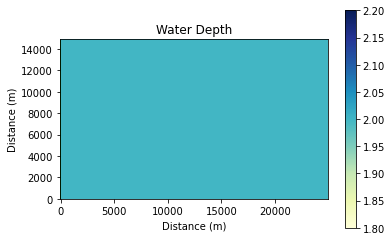

In [13]:
# visualize the domain
plot_depth(grid)
plt.title('Water Depth')
plt.show()

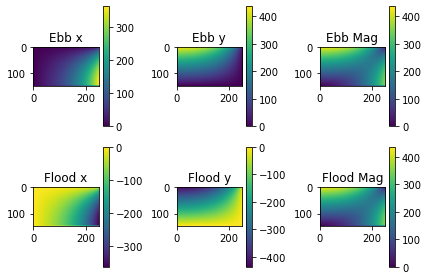

In [10]:
# plot velocity information
group_plot(gvals)
plt.show()

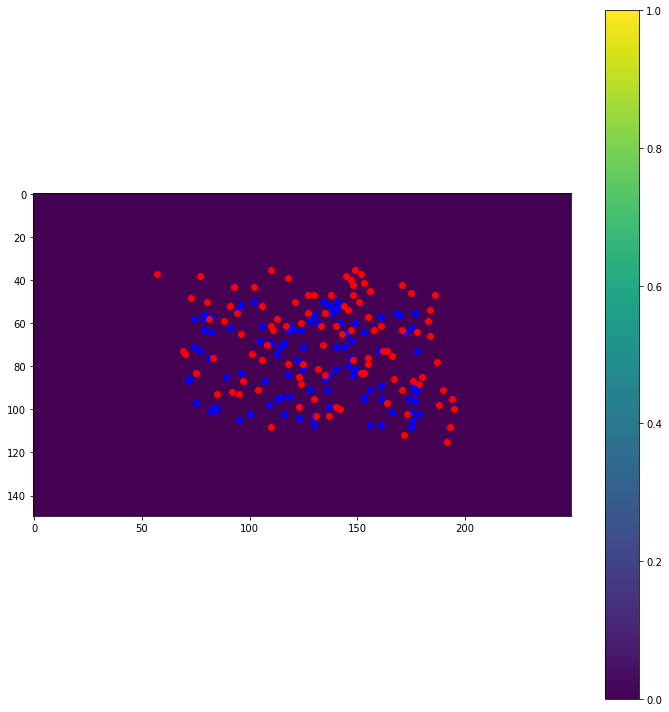

In [11]:
# plot particle locations on the roughness field
plt.figure(figsize=(10, 10))
# first plot initial locations as blue dots
plot_state(np.flipud(np.reshape(z,grid.shape)), 
           walk_data, iteration=0, target_time=None, c='b')
# then plot final locations as red dots
plot_state(np.flipud(np.reshape(z,grid.shape)), 
           walk_data, iteration=-1, target_time=None, c='r')
# make the colorbar - yellow for high roughness, purple for low
plt.colorbar()
# tighten layout
plt.tight_layout()
# show it
plt.show()

### Animated Results

While the above still image is nice, it does not totally reflect how the tides have influence the movement of the passive tracers. A better way of visualizing this is by animating the movement of the particles at each ebb and flood tide:

![simple_2d_gif](imgs/demo_Simple2D.gif)

With this visual we can see the oscillatory nature of the flow field and the way in which the particles move with the tides. 